# DL Final Project code

In [ ]:
## CODE FOR DEEP LEARNING FINAL PROJECT
# MEAN-FIELD VERSION

import math
import numpy as np
import copy
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import csv

from sklearn.preprocessing import normalize, minmax_scale
from sklearn.manifold import TSNE

def relu(x):
    return np.maximum(x, 0)

def deriv_relu(x):
    return (x > 0).astype(x.dtype)

def np_log(x):
    return np.log(np.clip(x, 1e-6, 1e+6))

# settings for matplotlib
cmap = plt.get_cmap('viridis')

In [ ]:
## DEFINING NEURAL NETWORK CLASS

class MFNN:
  def __init__(self, M, d):
    self.M, self.d = M, d

    self.W_init = np.random.randn(M, d)
    self.a_init = 2 * np.random.binomial(1, 0.5, M).astype('float64') - 1

    self.W, self.a = copy.deepcopy(self.W_init), copy.deepcopy(self.a_init)

    self.mask = np.ones(M).astype('float64')
    self.dW, self.da = None, None

  def reinitialize(self): # reinitialize before set_mask
    self.W, self.a = copy.deepcopy(self.W_init), copy.deepcopy(self.a_init)

  def random_initialize(self): # full reinitialization, do not use
    self.W_init = np.random.randn(M, d)
    self.a_init = 2 * np.random.binomial(1, 0.5, M).astype('float64') - 1
    self.W, self.a = copy.deepcopy(self.W_init), copy.deepcopy(self.a_init)

  def set_mask(self, mask):
    self.mask = mask
    self.a = np.multiply(self.a, self.mask)

  def get_mask(self):
    return self.mask

  def get_params(self):
    return self.W, np.multiply(self.a, self.mask)

  def get_grad(self):
    return self.dW, np.multiply(self.da, self.mask)

  def forward(self, x):
    pre = np.matmul(self.W, x) # pre-activation M*n
    yhat = np.matmul(self.a, relu(pre)) / self.M
    return yhat

  def update(self, x, y, train = True, temp = 0): # x is d*n
    n = len(y)
    pre = np.matmul(self.W, x) # pre-activation M*n
    yhat = np.matmul(self.a, relu(pre)) / self.M # prediction
    loss = np.mean(np.square(yhat - y))

    if train == True:

      self.dW = np.matmul(np.multiply(np.multiply(deriv_relu(pre), yhat - y), np.transpose([self.a])),
                          np.transpose(x)) * 2 / (n * self.M)
      self.da = np.matmul(relu(pre), yhat - y) * 2 / (n * self.M)

      self.W -= lr * self.dW + math.sqrt(2 * lr * temp) * np.random.randn(M, d)
      self.a -= lr * np.multiply(self.da, self.mask) + math.sqrt(2 * lr * temp) * np.random.randn(M)
      # all self.a instances are already masked

    return loss

In [ ]:
## SIMULATING TRAIN AND TEST DATASETS

d = 50 # data dim
n_train = 3000
n_test = 3000

M = 1000 # network width
max_epochs = 2000
lr = 100 # relative due to MF scale

M_teacher = M
teacher = MFNN(M_teacher, d)

def fun(x):
  return teacher.forward(x) + 0.1 * np.random.randn()

x_train = normalize(np.random.randn(d, n_train), axis = 0, norm = 'l2')
y_train = np.apply_along_axis(fun, 0, x_train)

x_test = normalize(np.random.randn(d, n_test), axis = 0, norm = 'l2')
y_test = np.apply_along_axis(fun, 0, x_test)

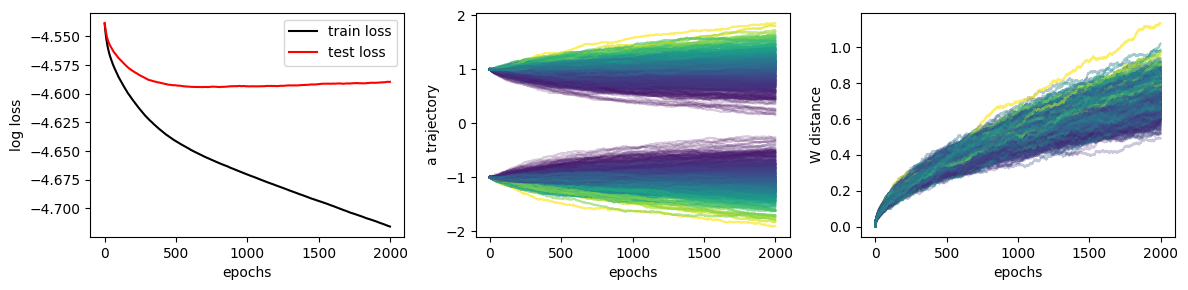

In [ ]:
## BASE TRAINING

model = MFNN(M, d)

temp =2e-8 # lambda

train_plot = []
test_plot = []
hist_grad = []
hist_a = []

for epoch in range(max_epochs):

  W, a = copy.deepcopy(model.get_params())
  hist_a.append(a)

  train_loss = model.update(x_train, y_train, temp = temp)
  test_loss = model.update(x_test, y_test, train = False, temp = temp)

  train_plot.append(train_loss)
  test_plot.append(test_loss)
  # print('train loss: {:.3f} \t test loss: {:.3f}'.format(train_loss, test_loss))

  dW, da = copy.deepcopy(model.get_grad())
  hist_grad.append(np.linalg.norm(W - model.W_init, axis = 1))

hist_a = np.asarray(hist_a)
hist_grad = np.asarray(hist_grad)

best_train_full = np.min(np.asarray(train_plot))
best_test_full = np.min(np.asarray(test_plot))

plt.figure(figsize=(12,3))

plt.subplot(1, 3, 1)

plt.plot(range(max_epochs), np_log(train_plot), 'k', label = 'train loss')
plt.plot(range(max_epochs), np_log(test_plot), 'r', label = 'test loss')
plt.legend()
plt.xlabel('epochs'); plt.ylabel('log loss')

plt.subplot(1, 3, 2)

col_a = np.square(2 * minmax_scale(hist_a[max_epochs - 1, :]) - 1)

for i in range(M):
  plt.plot(range(max_epochs), hist_a[:, i], color = cmap(col_a[i]), alpha = 0.2 + col_a[i] * 0.5)

plt.xlabel('epochs'); plt.ylabel('a trajectory')

plt.subplot(1, 3, 3)

for i in range(M):
  plt.plot(range(max_epochs), hist_grad[:, i], color = cmap(col_a[i]), alpha = 0.2 + col_a[i] * 0.5)

plt.xlabel('epochs'); plt.ylabel('W distance')

plt.tight_layout()
plt.show()

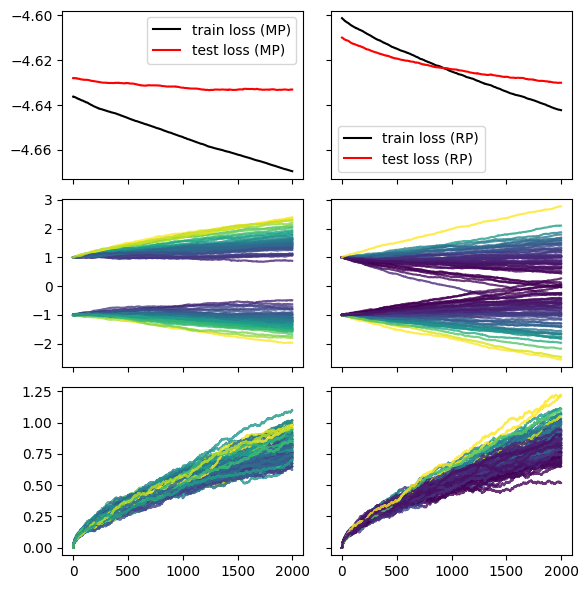

In [ ]:
# COMPARING MAGNITUDE AND RANDOM PRUNING (SINGLE INSTANCE)

m = 100 # fix a subnetwork size

mask_top = np.zeros(M)
mask_top[np.argpartition(np.abs(hist_a[max_epochs - 1, :]), - m)[-m:]] = 1 # magnitude pruning for |a|

mask_rand = np.zeros(M)
mask_rand[random.sample(range(M), m)] = 1 # random pruning

varcheck_top = []
varcheck_rand = []
target_top = random.choice([t for t in range(M) if mask_top[t] == 1]) # mask_top.tolist().index(1)
target_rand = random.choice([t for t in range(M) if mask_rand[t] == 1])

fig, ax = plt.subplots(3, 2, sharex = 'col', sharey = 'row', figsize = (6, 6))

for mode in range(2):

  if mode == 0:
    model.reinitialize()
    model.set_mask(mask_top)
  else:
    model.reinitialize()
    model.set_mask(mask_rand)

  train_plot_sub = []
  test_plot_sub = []
  hist_grad_sub = []
  hist_a_sub = []

  for epoch in range(max_epochs):

    W, a = copy.deepcopy(model.get_params())
    hist_a_sub.append(a)

    train_loss = model.update(x_train, y_train, temp = temp)
    test_loss = model.update(x_test, y_test, train = False, temp = temp)

    train_plot_sub.append(train_loss)
    test_plot_sub.append(test_loss)
    # print('train loss: {:.3f} \t test loss: {:.3f}'.format(train_loss, test_loss))

    dW, da = copy.deepcopy(model.get_grad())
    hist_grad_sub.append(np.linalg.norm(W - model.W_init, axis = 1))

  hist_a_sub = np.asarray(hist_a_sub)
  hist_grad_sub = np.asarray(hist_grad_sub)

  if mode == 0:
    delta_W_top = np.linalg.norm(model.W - model.W_init, axis = 1)
    hist_a_top = copy.deepcopy(hist_a_sub)
  else:
    delta_W_rand = np.linalg.norm(model.W - model.W_init, axis = 1)
    hist_a_rand = copy.deepcopy(hist_a_sub)

  ax[0, mode].plot(range(max_epochs), np_log(train_plot_sub), 'k', label = 'train loss ({})'.format((1 - mode) * 'MP' + mode * 'RP'))
  ax[0, mode].plot(range(max_epochs), np_log(test_plot_sub), 'r', label = 'test loss ({})'.format((1 - mode) * 'MP' + mode * 'RP'))
  ax[0, mode].legend()

  col_a_sub = np.square(2 * minmax_scale(hist_a_sub[max_epochs - 1, :]) - 1)

  for i in np.where(model.get_mask() == 1)[0]:
    ax[1, mode].plot(range(max_epochs), hist_a_sub[:, i], color = cmap(col_a_sub[i]), alpha = 0.8)

  for i in np.where(model.get_mask() == 1)[0]:
    ax[2, mode].plot(range(max_epochs), hist_grad_sub[:, i], color = cmap(col_a_sub[i]), alpha = 0.8)

fig.tight_layout()
fig.show()

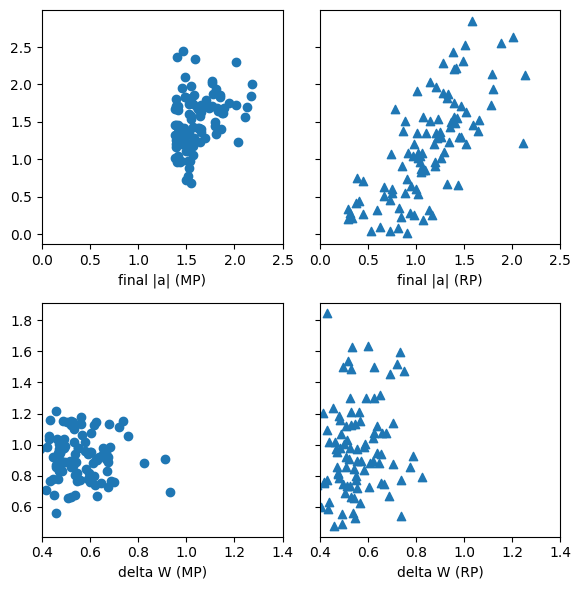

In [ ]:
figcor, axcor = plt.subplots(2, 2, sharex = None, sharey = 'row', figsize = (6, 6))

axcor[0, 0].scatter(np.abs(hist_a[max_epochs - 1, mask_top == 1]), np.abs(hist_a_top[max_epochs - 1, mask_top == 1]))
axcor[0, 0].set_xlim([0, 2.5])
axcor[0, 0].set_xlabel('final |a| (MP)')
axcor[0, 1].scatter(np.abs(hist_a[max_epochs - 1, mask_rand == 1]), np.abs(hist_a_rand[max_epochs - 1, mask_rand == 1]), marker = '^')
axcor[0, 1].set_xlim([0, 2.5])
axcor[0, 1].set_xlabel('final |a| (RP)')

axcor[1, 0].scatter(delta_W[mask_top == 1], delta_W_top[mask_top == 1])
axcor[1, 0].set_xlim([0.4, 1.4])
axcor[1, 0].set_xlabel('delta W (MP)')
axcor[1, 1].scatter(delta_W[mask_rand == 1], delta_W_rand[mask_rand == 1], marker = '^')
axcor[1, 1].set_xlim([0.4, 1.4])
axcor[1, 1].set_xlabel('delta W (RP)')

figcor.tight_layout()
figcor.show()

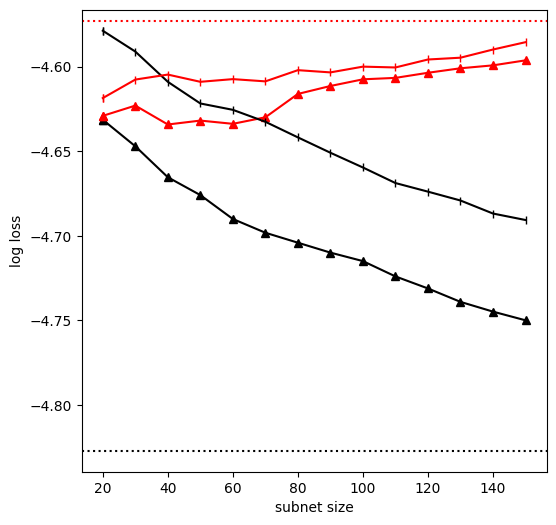

In [ ]:
## COMPARING MAGNITUDE AND RANDOM PRUNING (ACROSS SUBNET SIZES)
## TAKES TIME TO RUN

m_range = [20, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]

rand_shuffle = np.asarray(range(M))
random.shuffle(rand_shuffle)

best_train = [[], []] # [[top], [rand]]
best_test = [[], []]

fig, ax = plt.subplots(figsize = (6,6))

for m in m_range:
  for mode in range(2):

    if mode == 0:
      mask_top = np.zeros(M)
      mask_top[np.argpartition(np.abs(hist_a[max_epochs - 1, :]), - m)[-m:]] = 1

      model.reinitialize()
      model.set_mask(mask_top)

    else:
      mask_rand = np.zeros(M)
      mask_rand[rand_shuffle[:m]] = 1

      model.reinitialize()
      model.set_mask(mask_rand)

    train_plot_sub = []
    test_plot_sub = []

    for epoch in range(max_epochs):
      train_loss = model.update(x_train, y_train)
      test_loss = model.update(x_test, y_test, train = False)

      train_plot_sub.append(train_loss)
      test_plot_sub.append(test_loss)

    best_train[mode].append(np.min(np.asarray(train_plot_sub)))
    best_test[mode].append(np.min(np.asarray(test_plot_sub)))

# show loss graph
ax.plot(m_range, np_log(best_train[0]), 'k-^', label = 'train MP')
ax.plot(m_range, np_log(best_test[0]), 'r-^', label = 'test MP')
ax.plot(m_range, np_log(best_train[1]), 'k-|', label = 'train random')
ax.plot(m_range, np_log(best_test[1]), 'r-|', label = 'test random')
ax.axhline(y = np_log(best_train_full), color = 'k', linestyle = ':')
ax.axhline(y = np_log(best_test_full), color = 'r', linestyle = ':')
ax.set_xlabel('subnet size'); ax.set_ylabel('log loss')

fig.show()

In [ ]:
## t-SNE data generation

model.reinitialize()
model.set_mask(np.ones(M).astype('float64'))

record = np.array([max_epochs * 0.25, max_epochs * 0.50, max_epochs * 0.75, max_epochs - 1]).astype(int)
record_W = []

m = 100 # fix a subnetwork size

for epoch in range(max_epochs):

  if epoch in record:
    W, a = copy.deepcopy(model.get_params())
    record_W.append(W)

  if epoch == max_epochs - 1:
    W, a = copy.deepcopy(model.get_params())
    final_a = a

  train_loss = model.update(x_train, y_train)
  test_loss = model.update(x_test, y_test, train = False)

record_W = np.asarray(record_W)

index_top = np.zeros(M)
index_top[np.argpartition(np.abs(final_a), - m)[-m:]] = 1

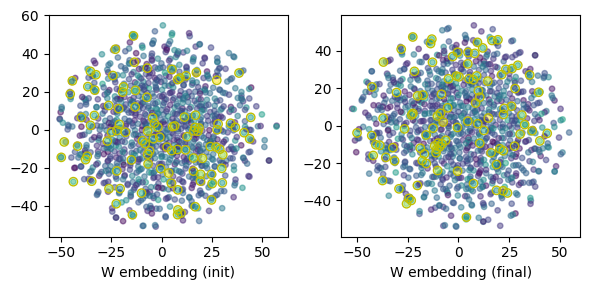

In [ ]:
## t-SNE plotting
tsne = TSNE(n_components = 2, method = 'exact', random_state = 42, perplexity = 20)

index_test = np.zeros(M)
index_test[np.argpartition(np.linalg.norm(model.W, axis = 1), - m)[-m:]] = 1

plt.figure(figsize=(6, 3))

fit_W = np.array(tsne.fit_transform(model.W_init)) # record_W[i, :] - model.W_init
plt.subplot(1, 2, 1)
plt.scatter(fit_W[:, 0], fit_W[:, 1], color = cmap(col_a), s = 15, alpha = 0.5)
plt.scatter(fit_W[index_top == 1, 0], fit_W[index_top == 1, 1], facecolor = 'none', edgecolor = 'y')
plt.xlabel('W embedding (init)')

fit_W = np.array(tsne.fit_transform(record_W[3, :])) # record_W[i, :] - model.W_init
plt.subplot(1, 2, 2)
plt.scatter(fit_W[:, 0], fit_W[:, 1], color = cmap(col_a), s = 15, alpha = 0.5)
plt.scatter(fit_W[index_top == 1, 0], fit_W[index_top == 1, 1], facecolor = 'none', edgecolor = 'y')
plt.xlabel('W embedding (final)')

plt.tight_layout()
plt.show()

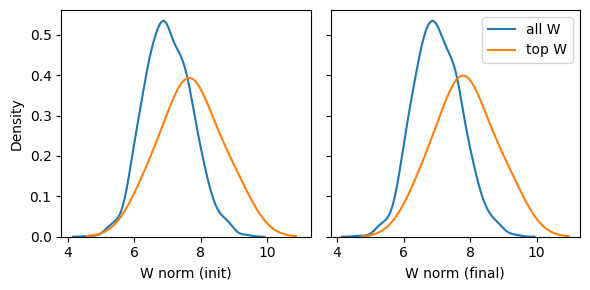

In [ ]:
## tracking pure W

model.reinitialize()
model.set_mask(np.ones(M).astype('float64'))

hist_pure = []
hist_a = []

for epoch in range(max_epochs):

  W, a = copy.deepcopy(model.get_params())
  hist_a.append(a)
  hist_pure.append(np.linalg.norm(W, axis = 1))

  train_loss = model.update(x_train, y_train)
  test_loss = model.update(x_test, y_test, train = False)

hist_a = np.asarray(hist_a)
hist_pure = np.asarray(hist_pure)
sns_top = np.argpartition(np.abs(hist_a[max_epochs - 1, :]), - num)[- num:]

figkde, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (6, 3))

sns.kdeplot(np.array(hist_pure[0, :]), ax = axes[0], label = 'all W')
sns.kdeplot(np.array(hist_pure[0, sns_top]), ax = axes[0], label = 'top W')
axes[0].set_xlabel('W norm (init)')

sns.kdeplot(np.array(hist_pure[max_epochs - 1, :]), ax = axes[1], label = 'all W')
sns.kdeplot(np.array(hist_pure[max_epochs - 1, sns_top]), ax = axes[1], label = 'top W')
axes[1].set_xlabel('W norm (final)')
axes[1].legend(loc = 'upper right')

figkde.tight_layout()
figkde.show()